In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import svd
from functions import *
from get_estimated_covariance import *
import scipy.stats
from scipy.interpolate import UnivariateSpline
import seaborn as sns
import pandas as pd
import tensorflow as tf
%matplotlib inline
%load_ext autoreload
%autoreload 2

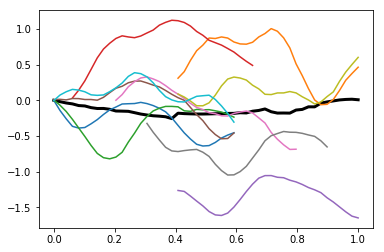

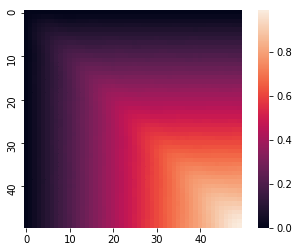

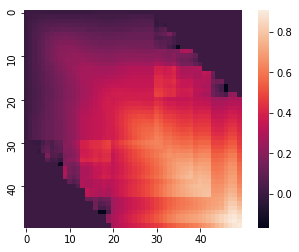

1


NameError: name 'tmp' is not defined

In [123]:
N = 50
t = np.linspace(0,1,N)
ma = np.meshgrid(t,t)
cov = np.minimum(ma[0],ma[1])
cov = cov + np.random.normal(0,0.001, cov.shape)
eigv, eigf = np.linalg.eigh(cov)
r = 10
rA = eigf[:,-r:] @ np.diag(eigv[-r:]) @ eigf[:,-r:].T
sqrtrA = eigf[:,-r:] @ np.diag(np.sqrt(eigv[-r:])) @ eigf[:,-r:].T

n=100
data = np.random.multivariate_normal(np.zeros(N),rA,n)

delta = 0.6
bounds, bounds2 = get_eff_bounds(delta=delta, N=N, n=n)

estmu = [hmu(data,i,bounds) for i in range(N)]

plt.plot(t,estmu,'k',linewidth=3)
for _ in range(10,20):
    s,st = bounds[_][0], bounds[_][1]
    plt.plot(t[s:st],data[_,s:st])
#plt.savefig('images/24/fragex.png',bbox_inches='tight', pad_inches=0)
plt.show()

trunc_cov = get_trunc_cov(data,bounds2)

sns.heatmap(rA, square=True,cbar_kws={"shrink": 1},xticklabels=10,yticklabels=10)
#plt.savefig('images/24/truecov.png',bbox_inches='tight', pad_inches=0)
plt.show()
sns.heatmap(trunc_cov, square=True,cbar_kws={"shrink": 1},xticklabels=10,yticklabels=10)
#plt.savefig('images/24/trunccov.png',bbox_inches='tight', pad_inches=0)
plt.show()

P = get_P(N,delta)
res = []
for i in range(1,r+1):
    print(i)
    #tmp = dog(i,P,trunc_cov)[1].reshape((N,-1))
    est = tmp @ tmp.T
    res.append(est)

bla = [np.linalg.norm(P*res[i]-trunc_cov)**2 for i in range(r)]

plt.plot(np.arange(1,r+1),bla)
#plt.savefig('images/24/obvals.png',bbox_inches='tight', pad_inches=0)
plt.show()

sns.heatmap(res[-1], square=True,cbar_kws={"shrink": 1},xticklabels=10,yticklabels=10)
#plt.savefig('images/24/estcov.png',bbox_inches='tight', pad_inches=0)
plt.show()

In [154]:
svd = np.linalg.svd(trunc_cov)

init_gamma = svd[0][:,:5] @ np.diag(svd[1][:5])


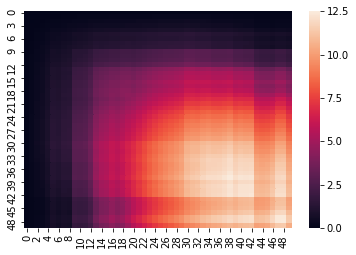

In [155]:
sns.heatmap(init_gamma @ init_gamma.T)

In [203]:
tf.reset_default_graph()
tf.set_random_seed(42)

n_epochs = 50000
learning_rate = 0.1

Rr = tf.constant(trunc_cov, dtype=tf.float32, name = "R")
Pp = tf.constant(P, dtype = tf.float32, name = "P")
in_gamma = tf.placeholder(dtype=tf.float32,shape = (N,5), name='ini')
gamma = tf.Variable(in_gamma + tf.random_normal([N,5],0,1),dtype=tf.float32, name = "gamma")

pred = tf.multiply(Pp,tf.matmul(gamma,gamma,transpose_b=True))
error = Rr - pred
mse = tf.reduce_mean(tf.square(error), name="mse")
#optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
#training_op = optimizer.minimize(mse) #tf.contrib.opt.ScipyOptimizerInterface(mse,options={'maxiter': 100000})
optimizer = tf.contrib.opt.ScipyOptimizerInterface(mse,options={'maxiter': 1000000, 'gtol':1e-50,'ftol':1e-50})
init = tf.global_variables_initializer()

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 0.000500
  Number of iterations: 113
  Number of functions evaluations: 133


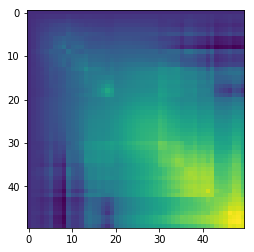

In [204]:
with tf.Session() as sess:
    sess.run(init,feed_dict={in_gamma:init_gamma.astype(np.float32)})
    optimizer.minimize(sess)
    best_gamma = gamma.eval()
plt.imshow(best_gamma @ best_gamma.T)

0


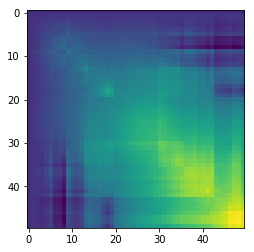

In [190]:
log = []
with tf.Session() as sess:
    sess.run(init,feed_dict={in_gamma:init_gamma.astype(np.float32)})

    for epoch in range(n_epochs):
        if epoch % 50==0:
            log.append([epoch,mse.eval()])
        if epoch % 100000 ==0:
            print(epoch)
        sess.run(training_op)
    
    best_gamma = gamma.eval()

plt.imshow(best_gamma @ best_gamma.T)

In [128]:
log = np.array(log)

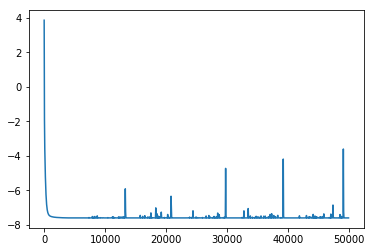

In [129]:
k=-1
plt.plot(log[:,0][:k],np.log(log[:,1])[:k])

In [138]:
np.linalg.norm(trunc_cov-rA)/np.linalg.norm(rA)

0.23951378557965539

In [139]:
estcov = np.cov(data,rowvar=False)

In [140]:
np.linalg.norm(best_gamma@ best_gamma.T-rA)/np.linalg.norm(rA)

0.20285377661652873

In [133]:
np.linalg.norm(np.cov(data,rowvar=False)-rA)/np.linalg.norm(rA)

0.075952216362687924